In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
import missingno as msno
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, precision_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.utils import compute_sample_weight
df=pd.read_csv("ai4i2020.csv")

In [41]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [42]:
df["Machine failure"].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

<Axes: >

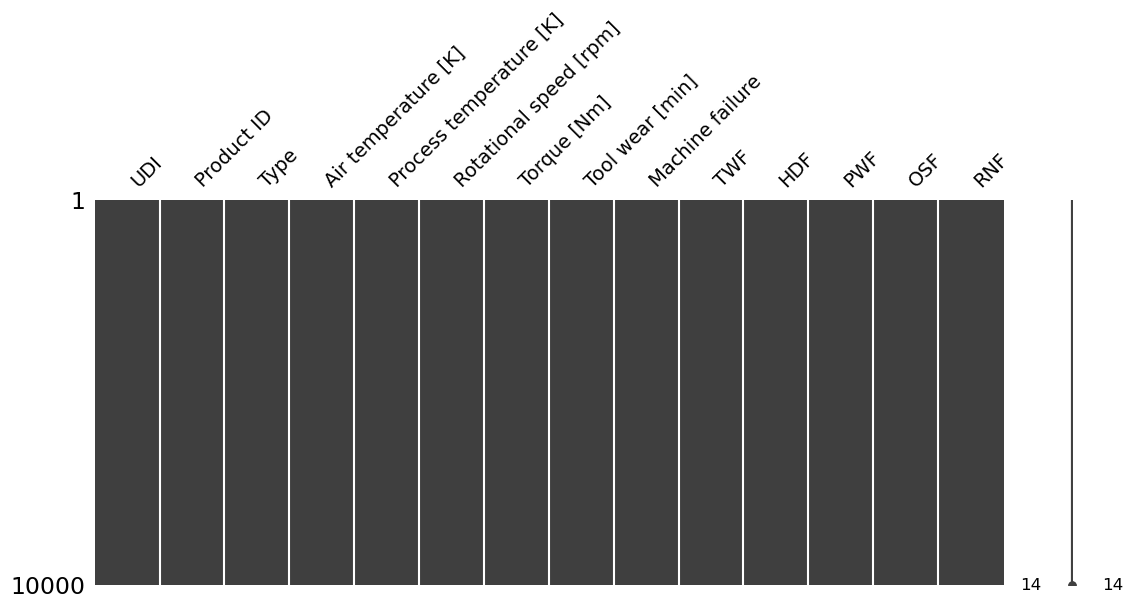

In [43]:
msno.matrix(df, figsize=(13,5), fontsize=14)

In [44]:
df.isnull().sum().to_frame()

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Machine failure,0
TWF,0


In [45]:
df["mf"]=df["TWF"]+df["HDF"]+df["PWF"]+df["OSF"]+df["RNF"]
for i in range(0,10000):
    if df.loc[i,"mf"]>1:
        df.loc[i,"mf"]=6
        df.loc[i,"TWF"]=0
        df.loc[i,"HDF"]=0
        df.loc[i,"PWF"]=0
        df.loc[i,"OSF"]=0
        df.loc[i,"RNF"]=0
    else:
        df.loc[i,"mf"]=0
        
df["TWF"]=df["TWF"].replace({1:2})
df["OSF"]=df["OSF"].replace({1:3})
df["RNF"]=df["RNF"].replace({1:4})
df["HDF"]=df["HDF"].replace({1:5})
df["Machine failure"]=df["TWF"]+df["HDF"]+df["PWF"]+df["OSF"]+df["RNF"]+df["mf"]

In [46]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,mf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0,0


In [47]:
sensor_data=df.drop(["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF", "mf"], axis=1)
columnas=["Type", "Air_temperature", "Process_temperature", "Rotational_speed",
          "Torque", "Tool_wear", "Machine_failure"]
sensor_data.columns=columnas

In [48]:
sensor_data

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0
9996,H,298.9,308.4,1632,31.8,17,0
9997,M,299.0,308.6,1645,33.4,22,0
9998,H,299.0,308.7,1408,48.5,25,0


<Axes: ylabel='Density'>

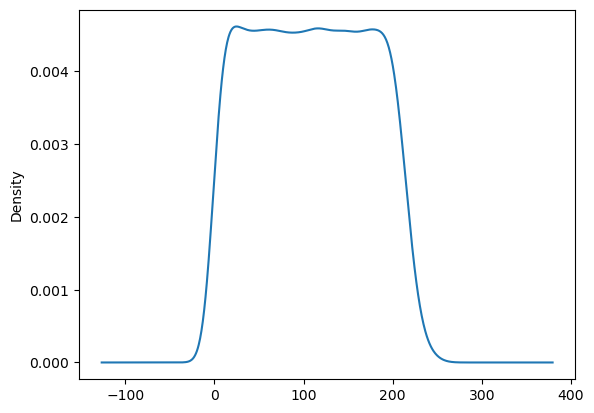

In [68]:
sensor_data["Tool_wear"].plot.density()

In [50]:
# sensor_data.to_csv("sensor_data.csv", index=False)

In [51]:
# sensor_data["Type"].replace({"L":0, "M":1, "H":2}, inplace=True)

In [52]:
sensor_data=pd.get_dummies(sensor_data, columns=["Type"], drop_first=False)

In [53]:
sensor_data["Machine_failure"].value_counts()

0    9652
5     106
1      80
3      78
2      42
6      24
4      18
Name: Machine_failure, dtype: int64

<Axes: title={'center': 'Tool_wear'}, xlabel='Machine_failure'>

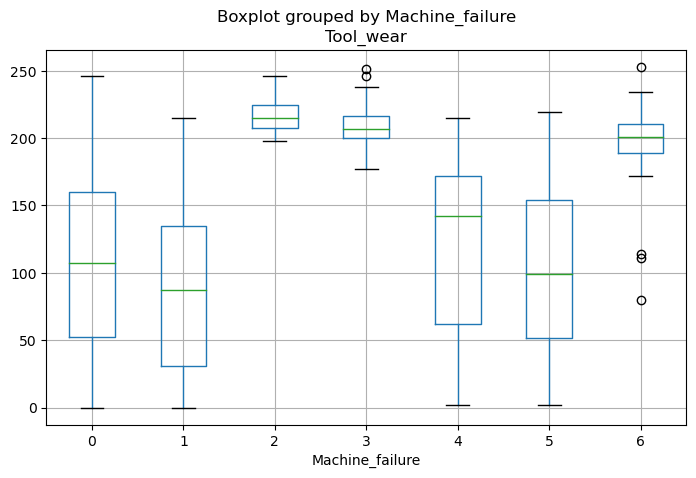

In [55]:
sensor_data.boxplot(column="Tool_wear", by="Machine_failure", figsize=(8,5))

In [56]:
X=sensor_data.drop(columns="Machine_failure")
y=sensor_data["Machine_failure"]
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y, train_size=0.7, random_state=0)

In [57]:
dummy_clf=DummyClassifier(strategy="most_frequent")
dummy_clf=dummy_clf.fit(X_train, y_train)
dummy_predict=dummy_clf.predict(X_test)
dummy_score=dummy_clf.score(X_test, y_test)
dummy_score

0.9653333333333334

In [58]:
weight_train=compute_sample_weight("balanced", y_train)
xgb_clf=XGBClassifier(max_depth=30, n_estimators=300)
xgb_clf.fit(X_train, y_train, sample_weight=weight_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [59]:
xgb_predict=xgb_clf.predict(X_test)
precision=precision_score(xgb_predict, y_test, average="micro")
precision

0.981

In [60]:
confusion_matrix(y_test, xgb_predict)

array([[2869,    6,   13,    3,    1,    4,    0],
       [   2,   21,    0,    0,    0,    0,    1],
       [  11,    0,    2,    0,    0,    0,    0],
       [   0,    0,    0,   20,    0,    0,    3],
       [   4,    0,    1,    0,    0,    0,    0],
       [   2,    0,    0,    1,    0,   29,    0],
       [   0,    2,    1,    2,    0,    0,    2]], dtype=int64)

In [61]:
resultados=classification_report(y_test, xgb_predict)

In [63]:
resultados

'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      2896\n           1       0.72      0.88      0.79        24\n           2       0.12      0.15      0.13        13\n           3       0.77      0.87      0.82        23\n           4       0.00      0.00      0.00         5\n           5       0.88      0.91      0.89        32\n           6       0.33      0.29      0.31         7\n\n    accuracy                           0.98      3000\n   macro avg       0.55      0.58      0.56      3000\nweighted avg       0.98      0.98      0.98      3000\n'